In [19]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import holidays
from matplotlib import rc
from datetime import datetime
import missingno as msno

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 경고 메시지 무시
warnings.filterwarnings('ignore')

# 시드 설정
np.random.seed(42)

print("라이브러리 임포트 완료!")


라이브러리 임포트 완료!


In [20]:
# 2021-2023년 지하철 데이터 로드
print("데이터 로딩 중...")
train2021 = pd.read_csv('데이터2/train_subway2021.csv')
train2022 = pd.read_csv('데이터2/train_subway2022.csv')
train2023 = pd.read_csv('데이터2/train_subway2023.csv')

print(f"2021년 데이터: {train2021.shape}")
print(f"2022년 데이터: {train2022.shape}")
print(f"2023년 데이터: {train2023.shape}")

# 데이터 병합
df = pd.concat([train2021, train2022, train2023], ignore_index=True)
print(f"\n병합된 데이터: {df.shape}")

# 메모리 정리
del train2021, train2022, train2023

print("\n데이터 병합 완료!")


데이터 로딩 중...
2021년 데이터: (5452143, 15)
2022년 데이터: (5396200, 15)
2023년 데이터: (5520981, 15)

병합된 데이터: (16369324, 15)

데이터 병합 완료!


In [21]:
# 기본 정보 확인
print("=== 데이터 기본 정보 ===")
print(df.info())
print("\n=== 처음 5행 ===")
print(df.head())
print("\n=== 기초 통계량 ===")
print(df.describe())


=== 데이터 기본 정보 ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16369324 entries, 0 to 16369323
Data columns (total 15 columns):
 #   Column    Dtype  
---  ------    -----  
 0   시간        int64  
 1   호선        int64  
 2   역번호       int64  
 3   역명        object 
 4   상하구분      object 
 5   AWS_지점코드  int64  
 6   기온        float64
 7   풍향        float64
 8   풍속        float64
 9   일강수량      float64
 10  시간강수량     float64
 11  상대습도      float64
 12  일사량       float64
 13  체감온도      float64
 14  혼잡도       int64  
dtypes: float64(8), int64(5), object(2)
memory usage: 1.8+ GB
None

=== 처음 5행 ===
           시간  호선  역번호   역명 상하구분  AWS_지점코드   기온     풍향   풍속  일강수량  시간강수량  \
0  2021010100   1  150  서울역   상선       419 -9.6  291.1  3.3   0.0    0.0   
1  2021010101   1  150  서울역   상선       419 -9.7  284.6  2.0   0.0    0.0   
2  2021010105   1  150  서울역   상선       419 -9.3  124.7  2.4   0.0    0.0   
3  2021010106   1  150  서울역   상선       419 -9.3  126.2  1.7   0.0    0.0   
4  2021010107 

In [22]:
#1. 시간 형식 지정 
# 2. 요일 정보 추출 (숫자 + 문자)
# 3. 공휴일 여부 추가
# 4. 시간 관련 파생 변수 생성
# 5. -99를 결측치로 변환

# 시간 컬럼 전처리
df['시간'] = pd.to_datetime(df['시간'].astype(str), format='%Y%m%d%H')

# 요일 및 공휴일 정보 추가
df['요일숫자'] = df['시간'].dt.weekday
weekday_map = ['월', '화', '수', '목', '금', '토', '일']
df['요일문자'] = df['요일숫자'].apply(lambda x: weekday_map[x])

# 한국 공휴일 확인
years = df['시간'].dt.year.unique()
kr_holidays = holidays.KR(years=years)
df['공휴일여부'] = df['시간'].dt.date.apply(lambda x: 1 if x in kr_holidays else 0)

# 시간 관련 피처 추가
df['년도'] = df['시간'].dt.year
df['월'] = df['시간'].dt.month
df['일'] = df['시간'].dt.day
df['시'] = df['시간'].dt.hour

# -99를 결측치로 변환
df.replace(-99, np.nan, inplace=True)

print("시간 전처리 완료!")
print(f"최종 데이터 형태: {df.shape}")
print(f"시간 범위: {df['시간'].min()} ~ {df['시간'].max()}")


시간 전처리 완료!
최종 데이터 형태: (16369324, 22)
시간 범위: 2021-01-01 00:00:00 ~ 2023-12-31 23:00:00


In [23]:
# 전체 결측치 현황
missing_counts = df.isnull().sum()
missing_ratio = (missing_counts / len(df)) * 100

missing_df = pd.DataFrame({
    '결측치 수': missing_counts,
    '결측률 (%)': missing_ratio.round(2)
})

print("=== 전체 결측치 현황 ===")
print(missing_df[missing_df['결측치 수'] > 0].sort_values('결측률 (%)', ascending=False))


=== 전체 결측치 현황 ===
         결측치 수  결측률 (%)
일사량    6064242    37.05
상대습도    844594     5.16
시간강수량   360796     2.20
일강수량    351574     2.15
풍향      230786     1.41
풍속      230786     1.41
기온      216468     1.32
체감온도       352     0.00


<Figure size 1500x800 with 0 Axes>

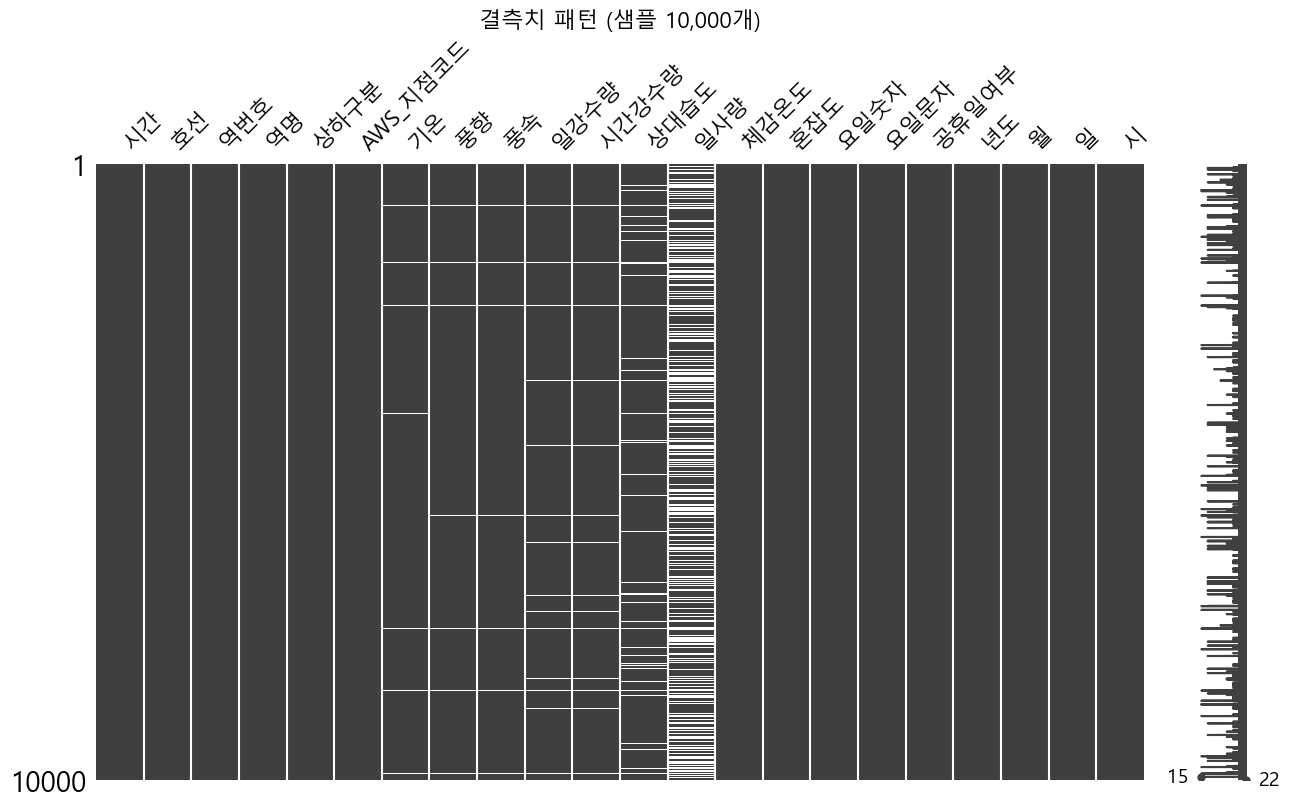

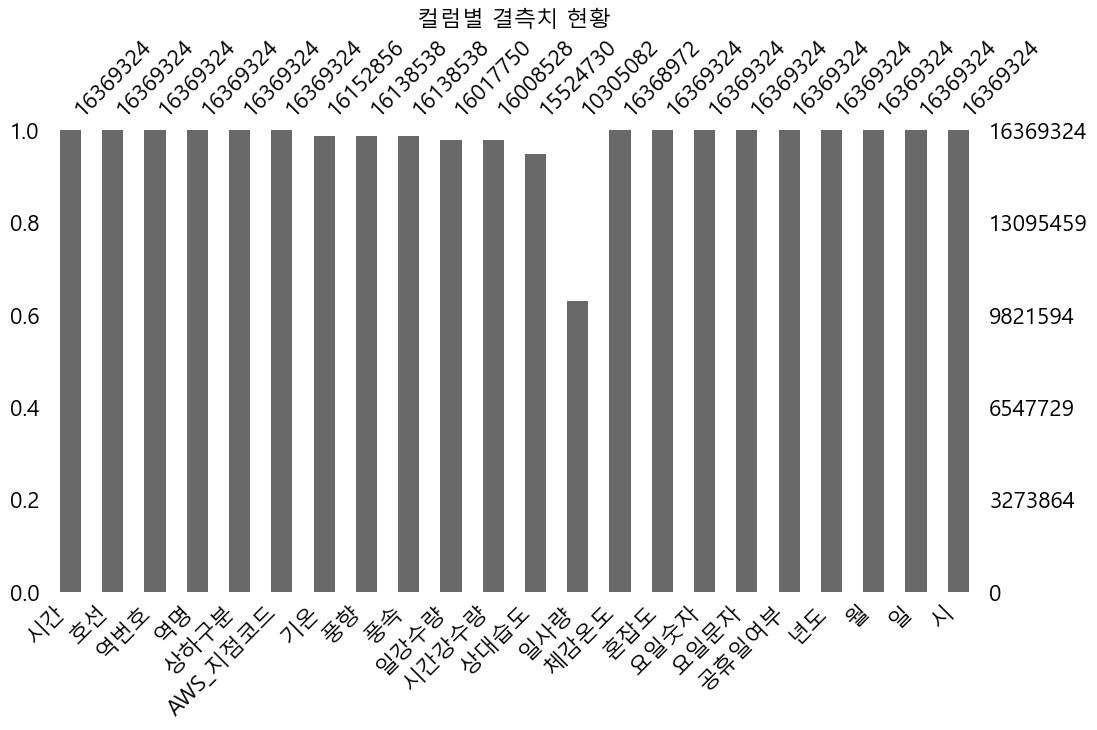

In [24]:
# 결측치 시각화 (missingno 라이브러리 사용)
plt.figure(figsize=(15, 8))
msno.matrix(df.sample(10000), figsize=(15, 8))
plt.title('결측치 패턴 (샘플 10,000개)', fontsize=16)
plt.show()

# 결측치 바 차트
plt.figure(figsize=(12, 6))
msno.bar(df, figsize=(12, 6))
plt.title('컬럼별 결측치 현황', fontsize=16)
plt.show()


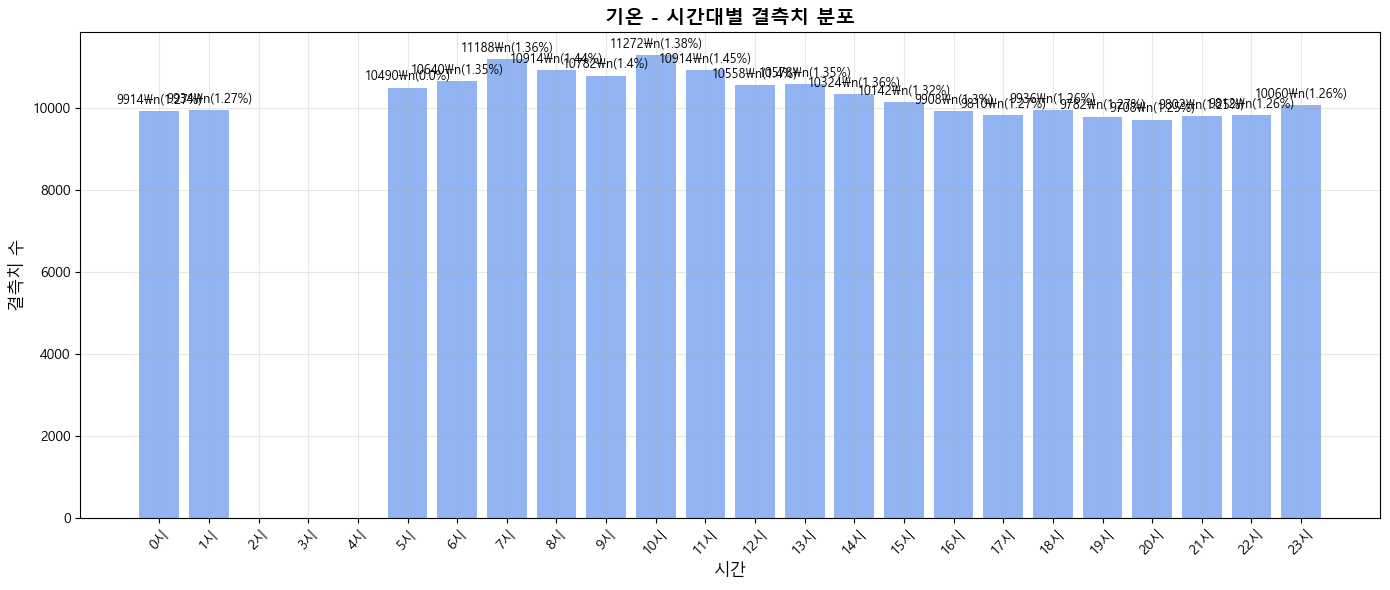

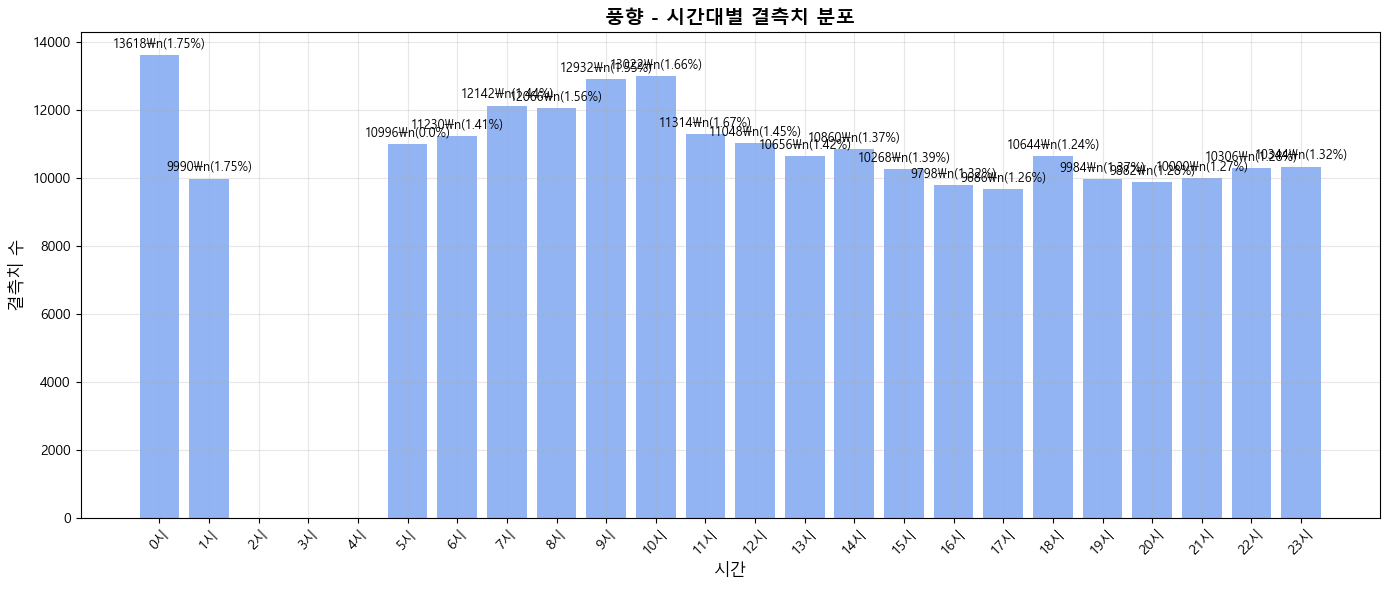

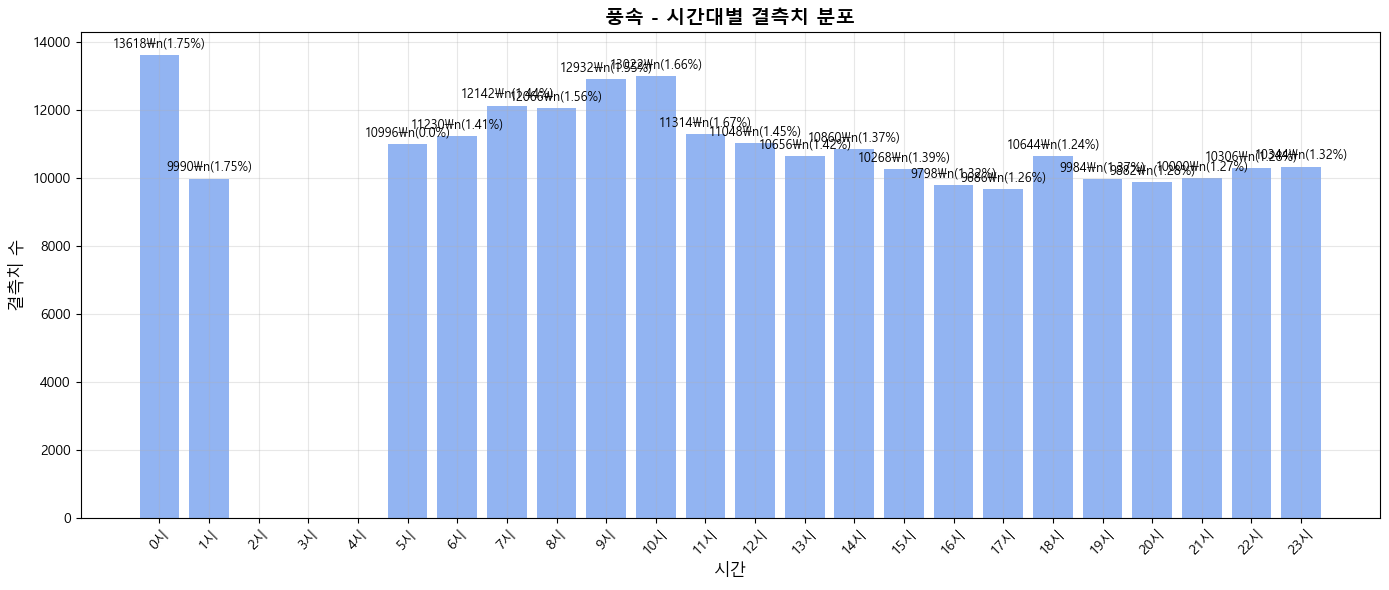

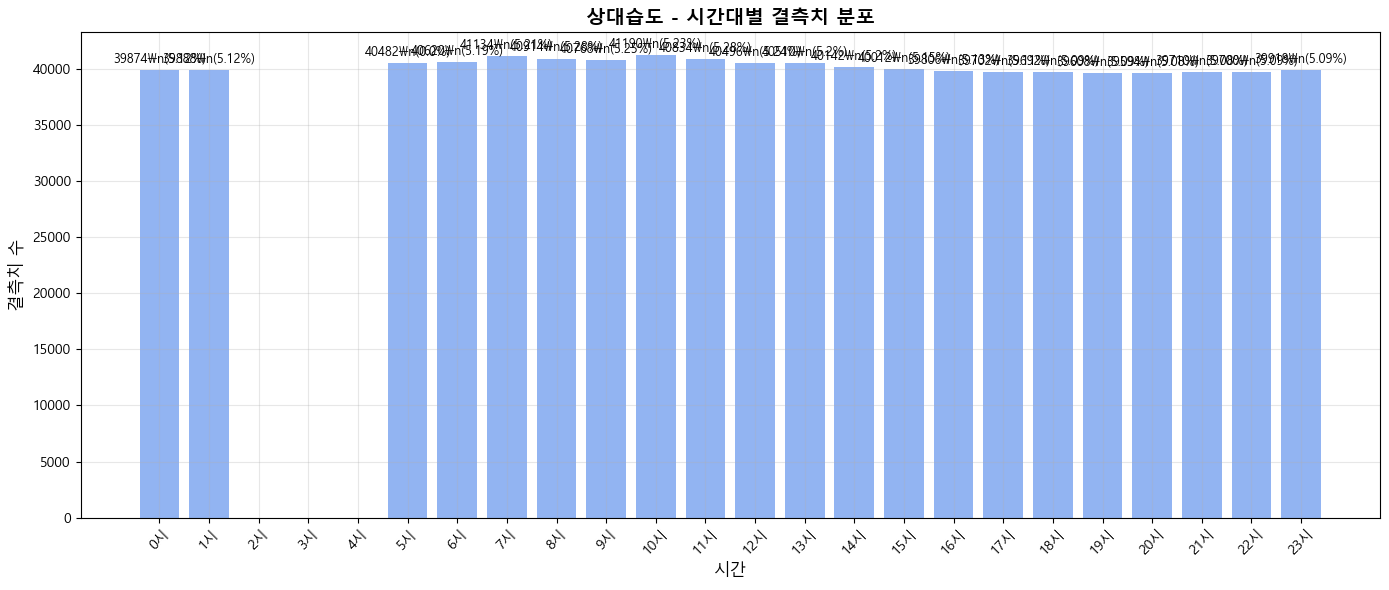

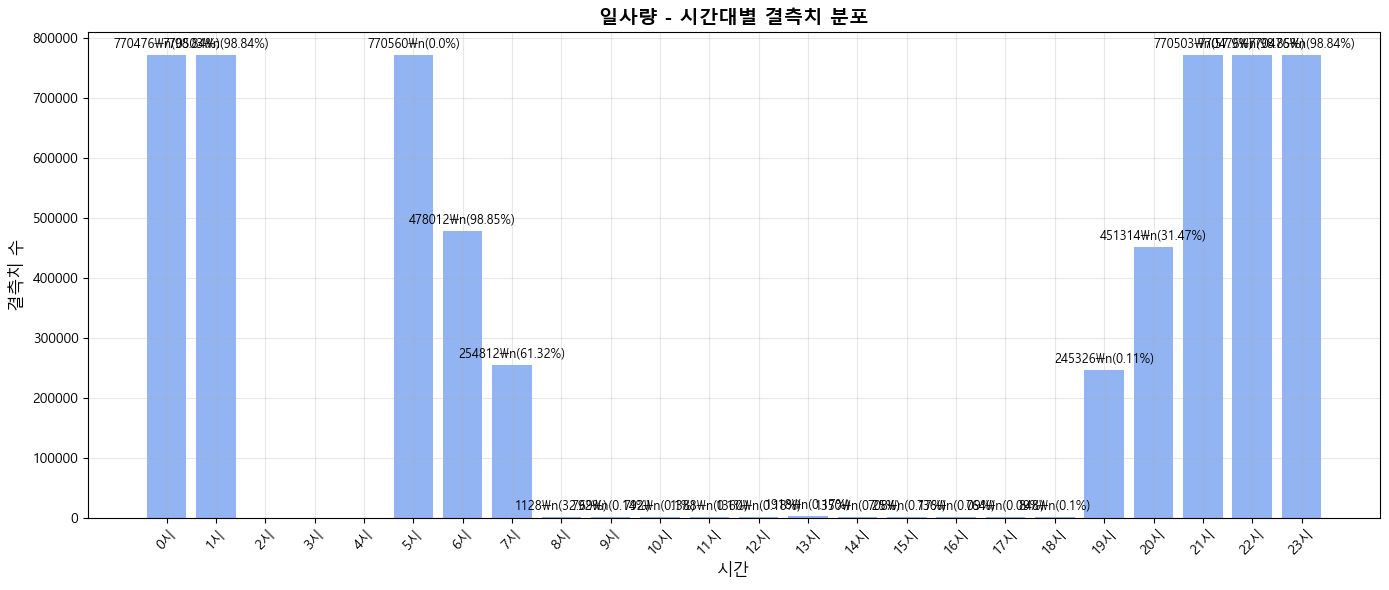

In [25]:
# 시간대별 결측치 분석 함수
def plot_missing_by_hour(df, column):
    """특정 컬럼의 시간대별 결측치를 시각화"""
    hourly_total = df['시'].value_counts().sort_index()
    hourly_missing = df[df[column].isnull()]['시'].value_counts().sort_index()
    hourly_missing_rate = (hourly_missing / hourly_total * 100).round(2)
    
    plt.figure(figsize=(14, 6))
    bars = plt.bar(hourly_missing.index, hourly_missing.values, color='cornflowerblue', alpha=0.7)
    plt.title(f'{column} - 시간대별 결측치 분포', fontsize=14, fontweight='bold')
    plt.xlabel('시간', fontsize=12)
    plt.ylabel('결측치 수', fontsize=12)
    plt.xticks(range(24), [f'{i}시' for i in range(24)], rotation=45)
    plt.grid(True, alpha=0.3)
    
    # 막대 위에 값 표시
    for bar in bars:
        if bar.get_height() > 0:
            hour = int(bar.get_x())
            count = int(bar.get_height())
            rate = hourly_missing_rate.get(hour, 0.0)
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(hourly_missing) * 0.01,
                    f'{count}\\n({rate}%)', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

# 주요 기상 변수들의 시간대별 결측치 분석
weather_columns = ['기온', '풍향', '풍속', '상대습도', '일사량']

for col in weather_columns:
    if df[col].isnull().sum() > 0:
        plot_missing_by_hour(df, col)


In [ ]:
# 각 역별로 시간대별 데이터 존재 여부 분석
print("=== 역별 시간대별 데이터 존재 여부 분석 ===")

# 고유 역 정보 추출
unique_stations = df[['호선', '역명', '상하구분']].drop_duplicates()
print(f"전체 고유 역(방향 포함): {len(unique_stations)}개")

# 각 역별로 시간대별 데이터 존재 개수 확인
station_hour_data = df.groupby(['호선', '역명', '상하구분', '시']).size().reset_index(name='데이터수')

# 모든 역과 모든 시간대의 조합 생성 (기대값)
all_hours = range(24)
all_combinations = []
for _, station in unique_stations.iterrows():
    for hour in all_hours:
        all_combinations.append({
            '호선': station['호선'],
            '역명': station['역명'], 
            '상하구분': station['상하구분'],
            '시': hour
        })

expected_combinations = pd.DataFrame(all_combinations)

# 실제 데이터와 기대 조합을 병합하여 누락된 시간대 찾기
merged = expected_combinations.merge(station_hour_data, 
                                   on=['호선', '역명', '상하구분', '시'], 
                                   how='left')
merged['데이터수'] = merged['데이터수'].fillna(0)
merged['데이터존재'] = (merged['데이터수'] > 0).astype(int)

print(f"\n전체 기대 조합 수: {len(expected_combinations)}")
print(f"실제 데이터가 존재하는 조합 수: {len(station_hour_data)}")
print(f"데이터가 없는 조합 수: {len(expected_combinations) - len(station_hour_data)}")

# 역별로 누락된 시간대 수 계산
missing_by_station = merged[merged['데이터존재'] == 0].groupby(['호선', '역명', '상하구분']).size().reset_index(name='누락시간대수')
missing_by_station['누락비율(%)'] = (missing_by_station['누락시간대수'] / 24 * 100).round(2)

print(f"\n=== 시간대별 데이터 누락이 심한 역 (상위 10개) ===")
print(missing_by_station.sort_values('누락시간대수', ascending=False).head(10))


=== 역별 시간대별 데이터 존재 여부 분석 ===


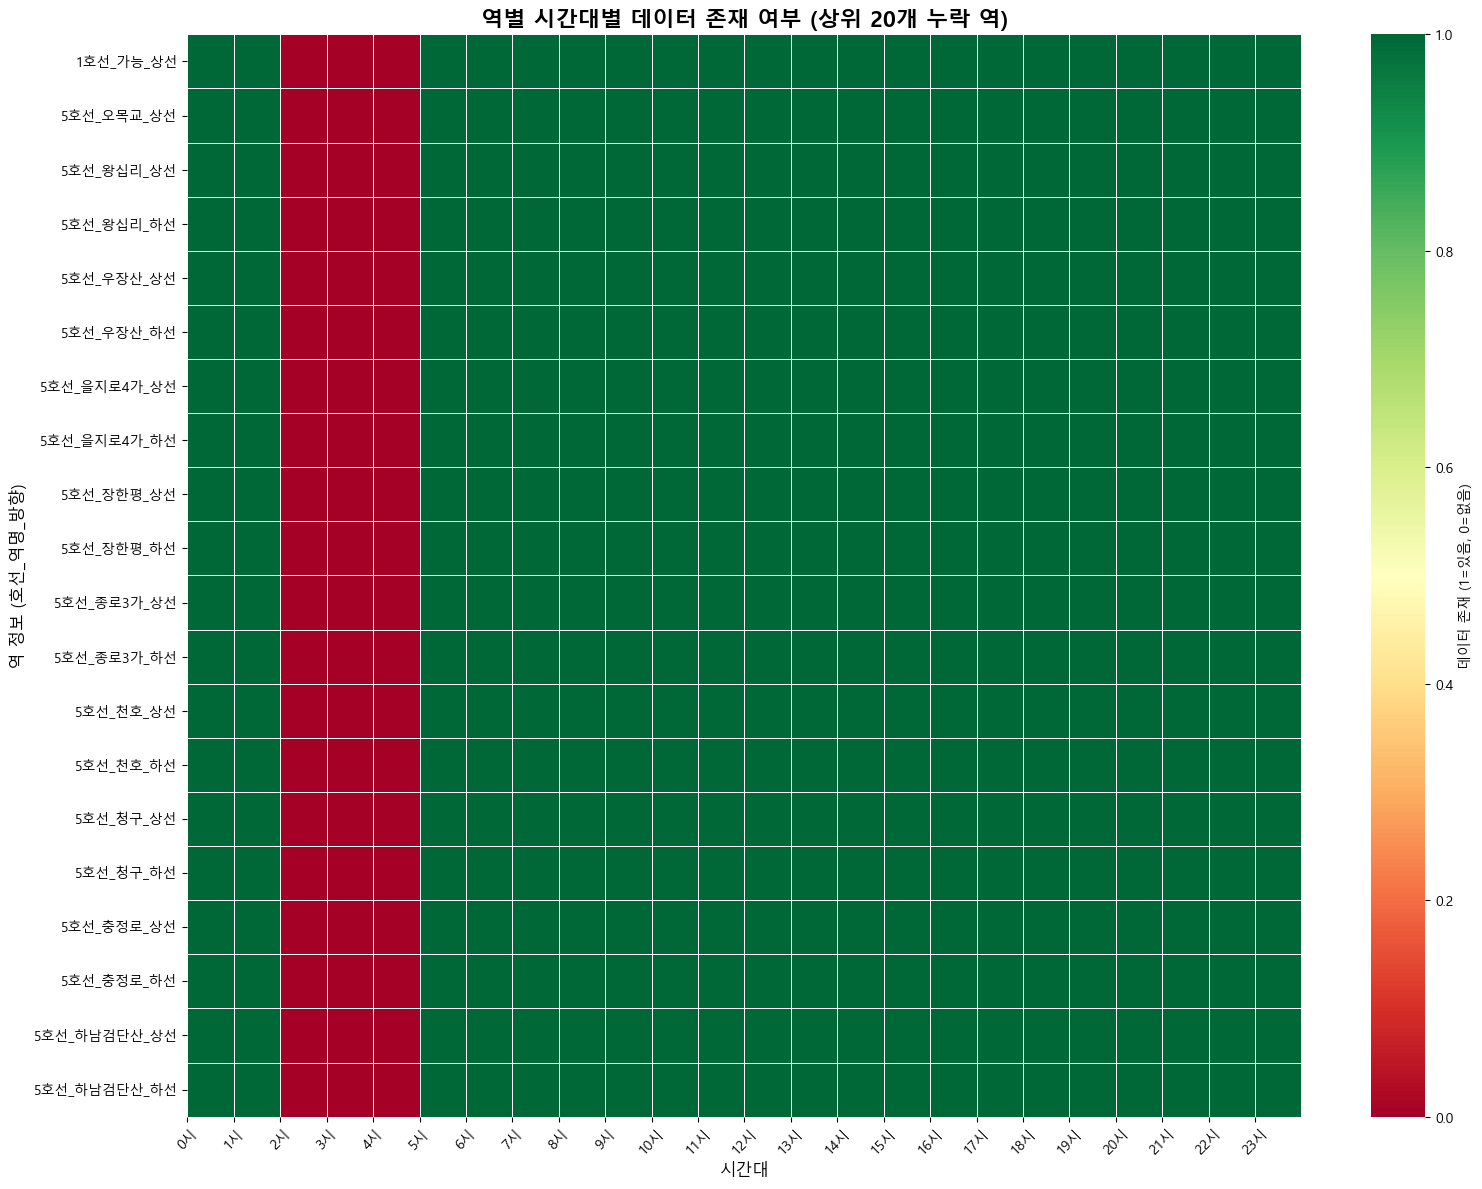

In [9]:
# 역별 시간대별 데이터 존재 여부 히트맵 시각화
# 데이터가 많으므로 상위 20개 누락 역만 시각화
top_missing_stations = missing_by_station.sort_values('누락시간대수', ascending=False).head(20)

# 히트맵용 데이터 준비
heatmap_data = []
for _, station in top_missing_stations.iterrows():
    station_data = merged[
        (merged['호선'] == station['호선']) & 
        (merged['역명'] == station['역명']) & 
        (merged['상하구분'] == station['상하구분'])
    ].copy()
    station_data['역_정보'] = f"{station['호선']}호선_{station['역명']}_{station['상하구분']}"
    heatmap_data.append(station_data)

if heatmap_data:
    heatmap_df = pd.concat(heatmap_data, ignore_index=True)
    
    # 피벗 테이블 생성 (역 x 시간대)
    pivot_table = heatmap_df.pivot_table(
        index='역_정보', 
        columns='시', 
        values='데이터존재', 
        fill_value=0
    )
    
    # 히트맵 그리기
    plt.figure(figsize=(16, 12))
    sns.heatmap(pivot_table, 
                cmap='RdYlGn', 
                cbar_kws={'label': '데이터 존재 (1=있음, 0=없음)'},
                linewidths=0.5,
                annot=False)
    plt.title('역별 시간대별 데이터 존재 여부 (상위 20개 누락 역)', fontsize=16, fontweight='bold')
    plt.xlabel('시간대', fontsize=12)
    plt.ylabel('역 정보 (호선_역명_방향)', fontsize=12)
    plt.xticks(range(24), [f'{i}시' for i in range(24)], rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
else:
    print("히트맵을 그릴 데이터가 없습니다.")


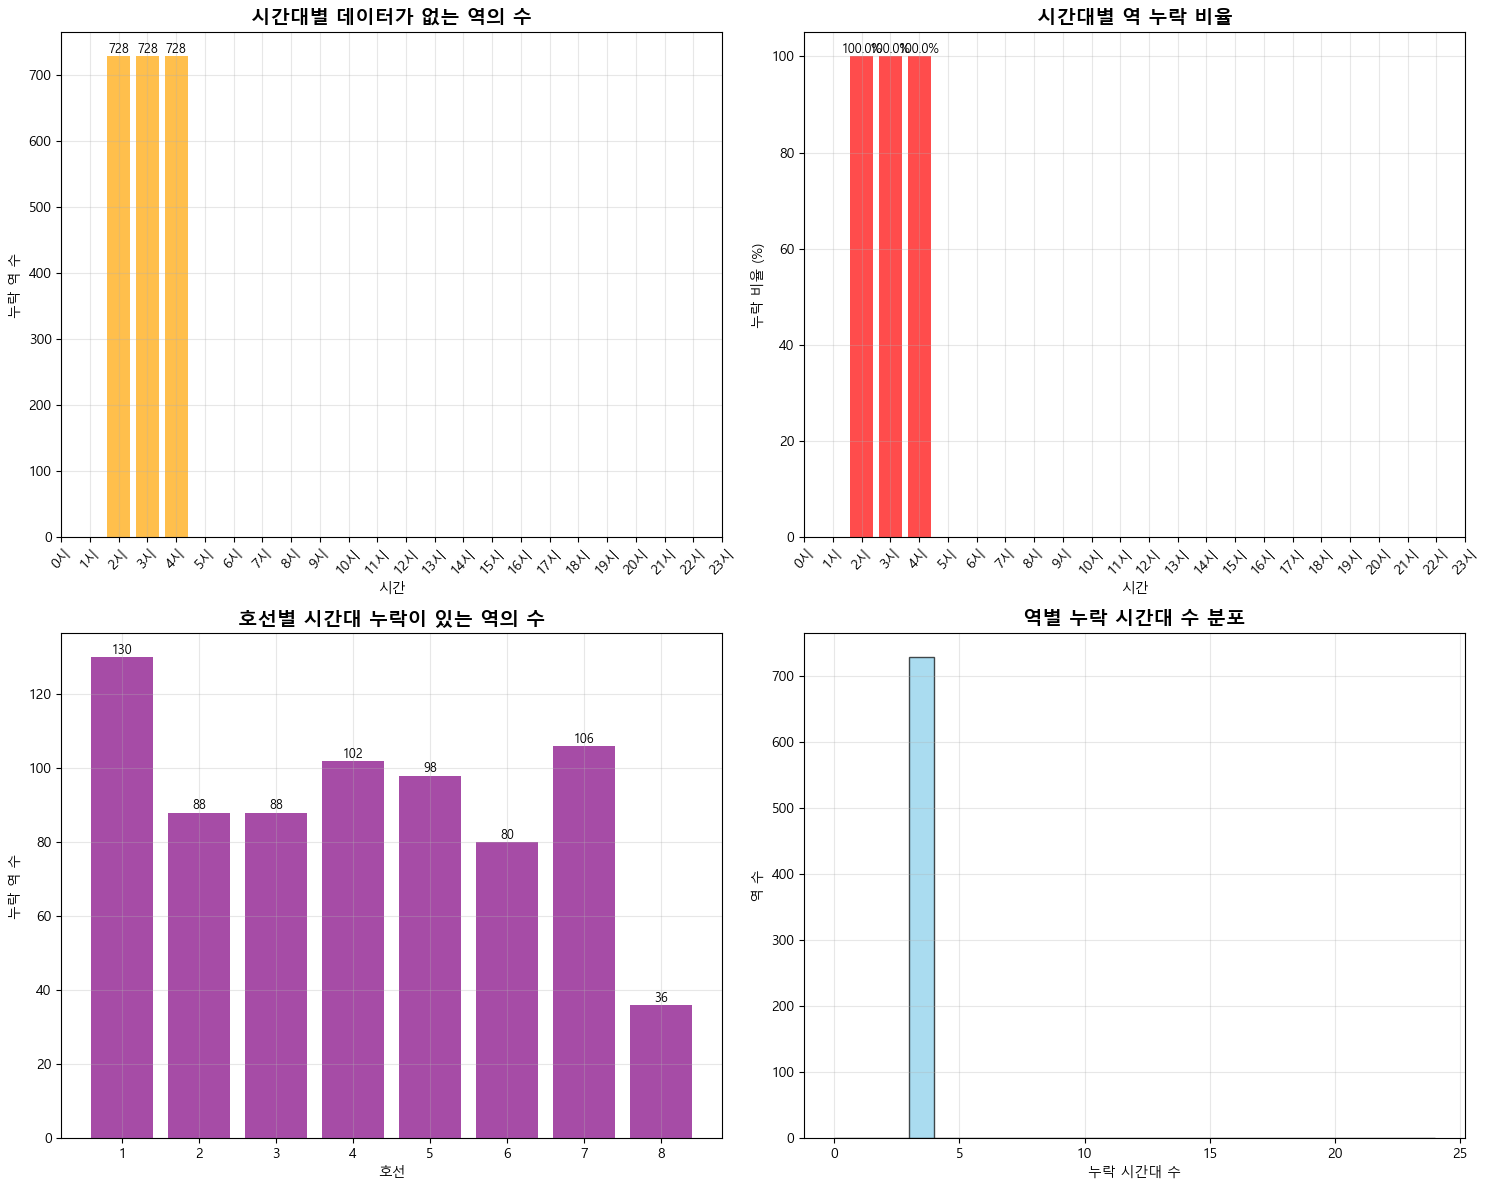


=== 시간대별 데이터 누락 요약 ===
평균적으로 시간대당 728.0개 역에서 데이터 누락
가장 많이 누락되는 시간대: 2시 (728개 역)
전체 역 중 적어도 하나의 시간대에서 데이터가 누락된 역: 728개
모든 시간대의 데이터가 완전한 역: 0개


In [10]:
# 시간대별로 데이터가 없는 역의 수 분석
missing_by_hour = merged[merged['데이터존재'] == 0].groupby('시').size().reset_index(name='누락역수')
total_stations = len(unique_stations)
missing_by_hour['누락비율(%)'] = (missing_by_hour['누락역수'] / total_stations * 100).round(2)

# 시간대별 누락 패턴 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 시간대별 누락 역 수
bars1 = axes[0, 0].bar(missing_by_hour['시'], missing_by_hour['누락역수'], color='orange', alpha=0.7)
axes[0, 0].set_title('시간대별 데이터가 없는 역의 수', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('시간')
axes[0, 0].set_ylabel('누락 역 수')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(24))
axes[0, 0].set_xticklabels([f'{i}시' for i in range(24)], rotation=45)

# 막대 위에 값 표시
for bar in bars1:
    height = bar.get_height()
    if height > 0:
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 1,
                        f'{int(height)}', ha='center', va='bottom', fontsize=9)

# 2. 시간대별 누락 비율
bars2 = axes[0, 1].bar(missing_by_hour['시'], missing_by_hour['누락비율(%)'], color='red', alpha=0.7)
axes[0, 1].set_title('시간대별 역 누락 비율', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('시간')
axes[0, 1].set_ylabel('누락 비율 (%)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(24))
axes[0, 1].set_xticklabels([f'{i}시' for i in range(24)], rotation=45)

# 막대 위에 값 표시
for bar in bars2:
    height = bar.get_height()
    if height > 0:
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                        f'{height:.1f}%', ha='center', va='bottom', fontsize=9)

# 3. 호선별 누락 역 수
missing_by_line = missing_by_station.groupby('호선')['누락시간대수'].agg(['count', 'mean']).reset_index()
missing_by_line.columns = ['호선', '누락역수', '평균누락시간대']
bars3 = axes[1, 0].bar(missing_by_line['호선'].astype(str), missing_by_line['누락역수'], color='purple', alpha=0.7)
axes[1, 0].set_title('호선별 시간대 누락이 있는 역의 수', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('호선')
axes[1, 0].set_ylabel('누락 역 수')
axes[1, 0].grid(True, alpha=0.3)

# 막대 위에 값 표시
for bar in bars3:
    height = bar.get_height()
    if height > 0:
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                        f'{int(height)}', ha='center', va='bottom', fontsize=9)

# 4. 누락 시간대 수 분포
axes[1, 1].hist(missing_by_station['누락시간대수'], bins=range(0, 25), color='skyblue', alpha=0.7, edgecolor='black')
axes[1, 1].set_title('역별 누락 시간대 수 분포', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('누락 시간대 수')
axes[1, 1].set_ylabel('역 수')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 요약 통계
print(f"\n=== 시간대별 데이터 누락 요약 ===")
print(f"평균적으로 시간대당 {missing_by_hour['누락역수'].mean():.1f}개 역에서 데이터 누락")
print(f"가장 많이 누락되는 시간대: {missing_by_hour.loc[missing_by_hour['누락역수'].idxmax(), '시']}시 ({missing_by_hour['누락역수'].max()}개 역)")
print(f"전체 역 중 적어도 하나의 시간대에서 데이터가 누락된 역: {len(missing_by_station)}개")
print(f"모든 시간대의 데이터가 완전한 역: {len(unique_stations) - len(missing_by_station)}개")


In [ ]:
# 전체 시간 범위 생성 (2021~2023, 매시간)
full_time_range = pd.date_range(start='2021-01-01 00:00', end='2023-12-31 23:00', freq='H')
total_expected_records = len(full_time_range)

print(f"예상 총 시간 수: {total_expected_records}")

# 각 역별 고유 시간 수 계산
station_time_counts = df.groupby(['호선', '역명', '상하구분'])['시간'].nunique().reset_index()
station_time_counts['완성도(%)'] = (station_time_counts['시간'] / total_expected_records * 100).round(2)
station_time_counts['누락_시간수'] = total_expected_records - station_time_counts['시간']

print("\n=== 역별 데이터 완성도 (상위 10개) ===")
print(station_time_counts.sort_values('완성도(%)', ascending=False).head(10))

print("\n=== 역별 데이터 완성도 (하위 10개) ===")
print(station_time_counts.sort_values('완성도(%)', ascending=True).head(10))


예상 총 시간 수: 26280

=== 역별 데이터 완성도 (상위 10개) ===
     호선     역명 상하구분     시간  완성도(%)  누락_시간수
0     1     가능   상선  22680    86.3    3600
495   5    충정로   하선  22680    86.3    3600
475   5  영등포구청   하선  22680    86.3    3600
476   5  영등포시장   상선  22680    86.3    3600
477   5  영등포시장   하선  22680    86.3    3600
478   5    오목교   상선  22680    86.3    3600
479   5    오목교   하선  22680    86.3    3600
480   5    왕십리   상선  22680    86.3    3600
481   5    왕십리   하선  22679    86.3    3601
482   5    우장산   상선  22680    86.3    3600

=== 역별 데이터 완성도 (하위 10개) ===
     호선     역명 상하구분     시간  완성도(%)  누락_시간수
102   1     전곡   상선    336    1.28   25944
124   1     청산   상선    336    1.28   25944
85    1     연천   하선    336    1.28   25944
103   1     전곡   하선    336    1.28   25944
84    1     연천   상선    336    1.28   25944
125   1     청산   하선    336    1.28   25944
344   4  별내별가람   상선  13566   51.62   12714
345   4  별내별가람   하선  13566   51.62   12714
388   4     진접   상선  13566   51.62   12714
374   4     오남   상선  1

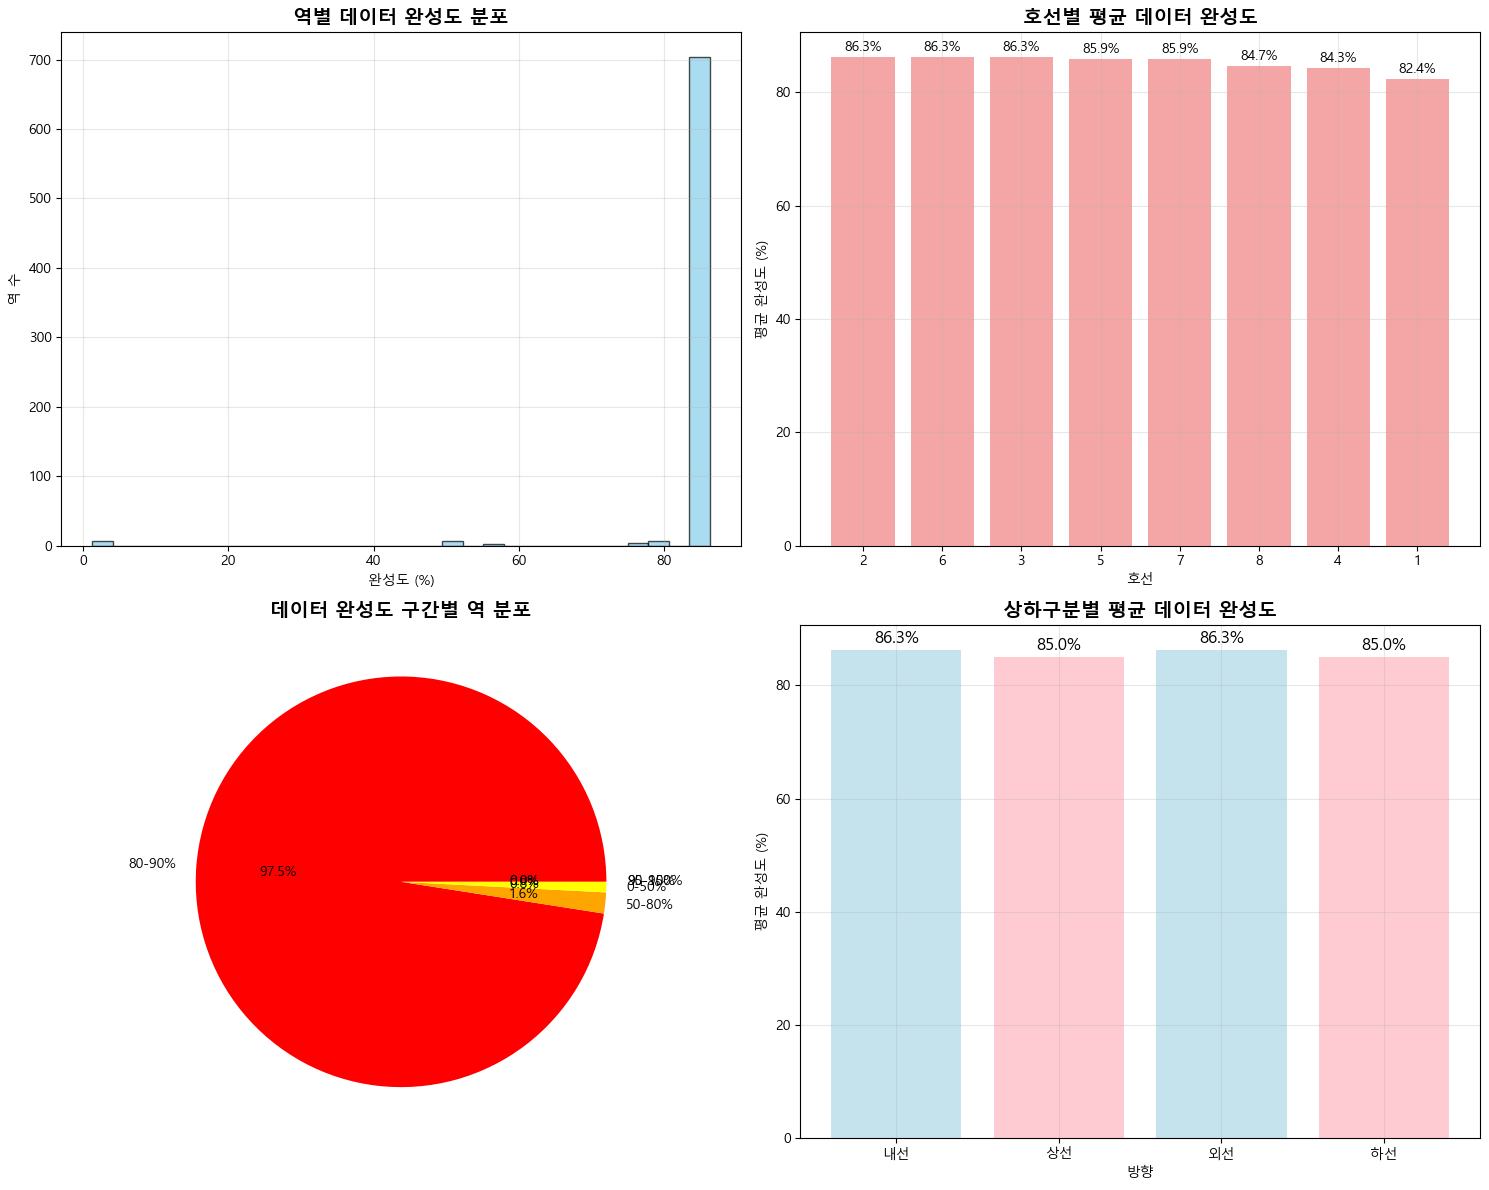

In [ ]:
# 데이터 완성도 분포 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 완성도 히스토그램
axes[0, 0].hist(station_time_counts['완성도(%)'], bins=30, color='skyblue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('역별 데이터 완성도 분포', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('완성도 (%)')
axes[0, 0].set_ylabel('역 수')
axes[0, 0].grid(True, alpha=0.3)

# 2. 호선별 평균 완성도
line_completeness = station_time_counts.groupby('호선')['완성도(%)'].mean().sort_values(ascending=False)
bars = axes[0, 1].bar(line_completeness.index.astype(str), line_completeness.values, color='lightcoral', alpha=0.7)
axes[0, 1].set_title('호선별 평균 데이터 완성도', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('호선')
axes[0, 1].set_ylabel('평균 완성도 (%)')
axes[0, 1].grid(True, alpha=0.3)

# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=10)

# 3. 완성도별 역 개수
completeness_bins = pd.cut(station_time_counts['완성도(%)'], bins=[0, 50, 80, 90, 95, 100], 
                          labels=['0-50%', '50-80%', '80-90%', '90-95%', '95-100%'])
completeness_counts = completeness_bins.value_counts()
axes[1, 0].pie(completeness_counts.values, labels=completeness_counts.index, autopct='%1.1f%%', 
               colors=['red', 'orange', 'yellow', 'lightgreen', 'green'])
axes[1, 0].set_title('데이터 완성도 구간별 역 분포', fontsize=14, fontweight='bold')

# 4. 상하구분별 완성도
direction_completeness = station_time_counts.groupby('상하구분')['완성도(%)'].mean()
bars = axes[1, 1].bar(direction_completeness.index, direction_completeness.values, 
                      color=['lightblue', 'lightpink'], alpha=0.7)
axes[1, 1].set_title('상하구분별 평균 데이터 완성도', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('방향')
axes[1, 1].set_ylabel('평균 완성도 (%)')
axes[1, 1].grid(True, alpha=0.3)

# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()


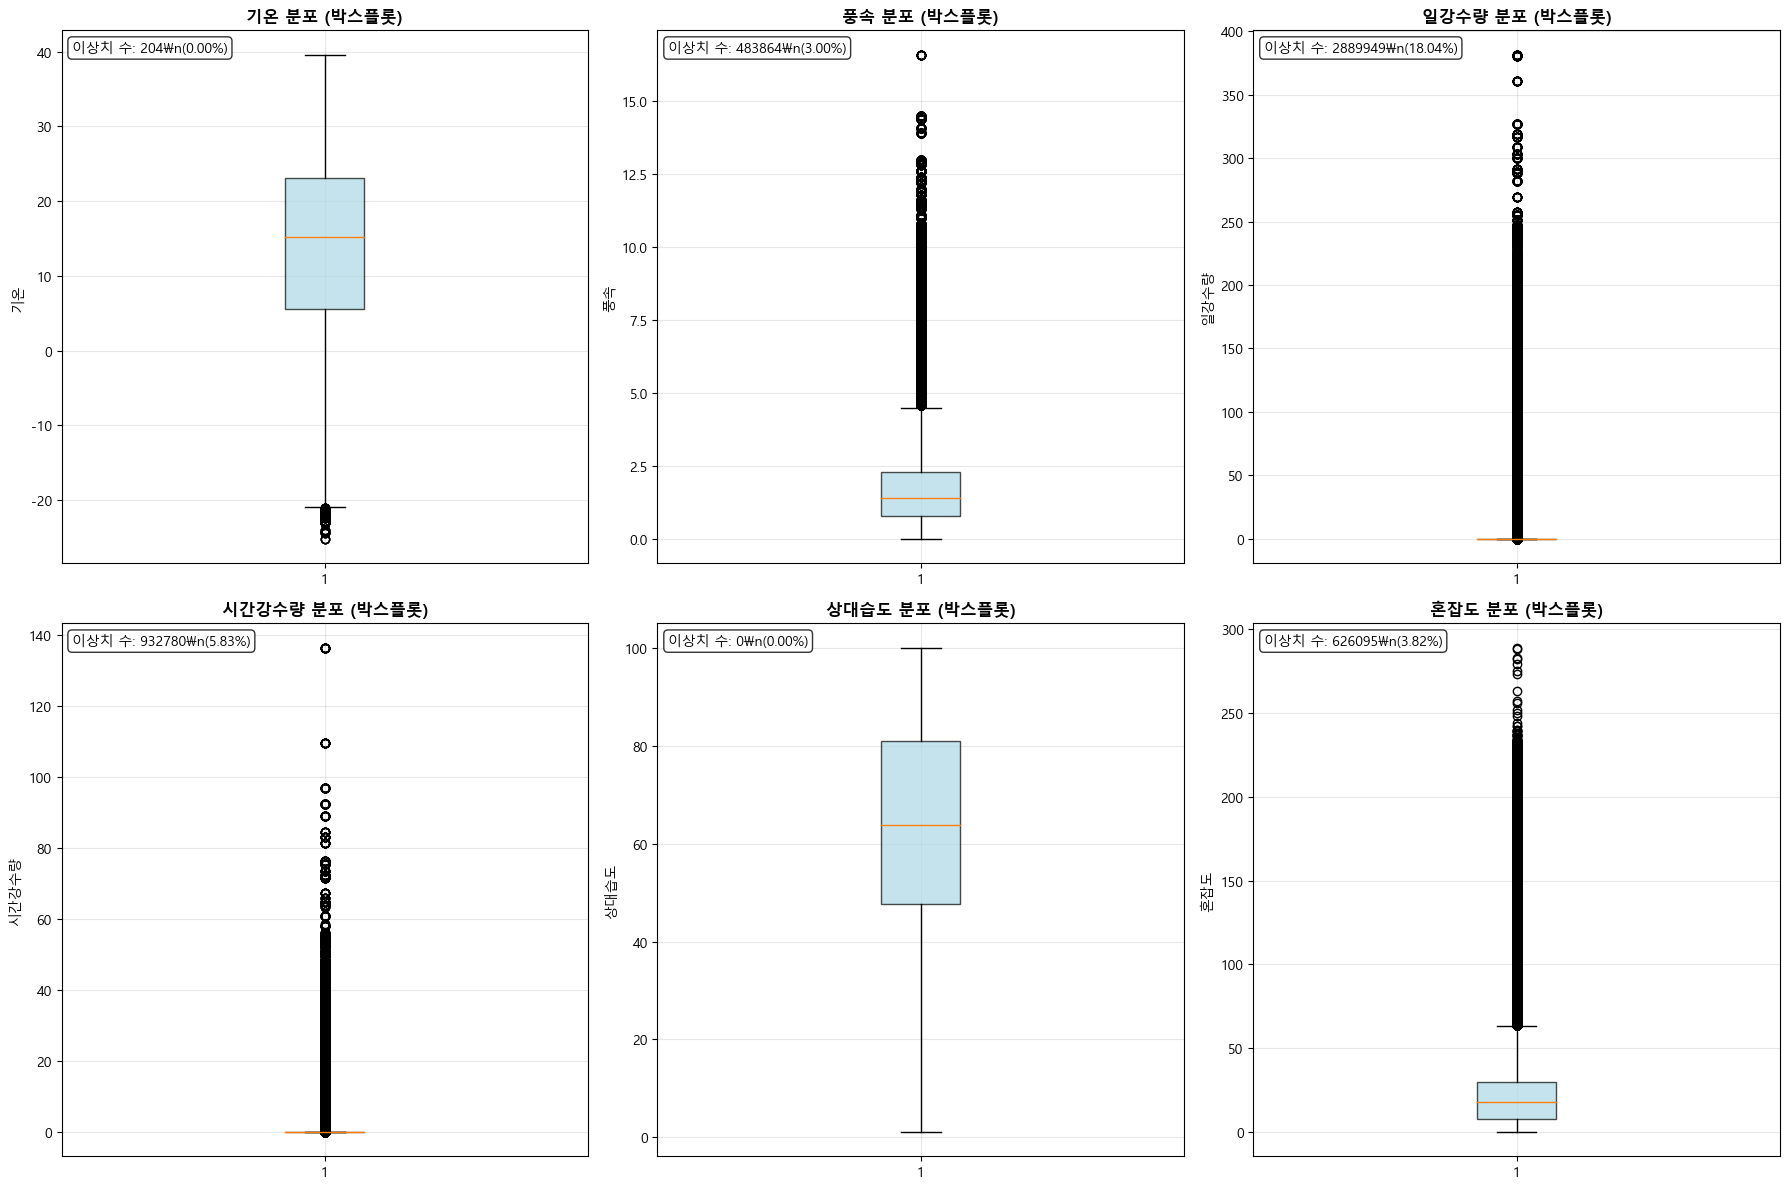

In [ ]:
# 수치형 변수들의 이상치 분석
numeric_columns = ['기온', '풍속', '일강수량', '시간강수량', '상대습도', '혼잡도']

# 박스플롯으로 이상치 시각화
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_columns):
    if col in df.columns:
        # 결측치 제외하고 박스플롯 그리기
        data_no_nan = df[col].dropna()
        axes[i].boxplot(data_no_nan, patch_artist=True, 
                       boxprops=dict(facecolor='lightblue', alpha=0.7))
        axes[i].set_title(f'{col} 분포 (박스플롯)', fontsize=12, fontweight='bold')
        axes[i].set_ylabel(col)
        axes[i].grid(True, alpha=0.3)
        
        # 기본 통계량 표시
        q1 = data_no_nan.quantile(0.25)
        q3 = data_no_nan.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = data_no_nan[(data_no_nan < lower_bound) | (data_no_nan > upper_bound)]
        
        axes[i].text(0.02, 0.98, f'이상치 수: {len(outliers)}\\n({len(outliers)/len(data_no_nan)*100:.2f}%)', 
                    transform=axes[i].transAxes, verticalalignment='top', 
                    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()


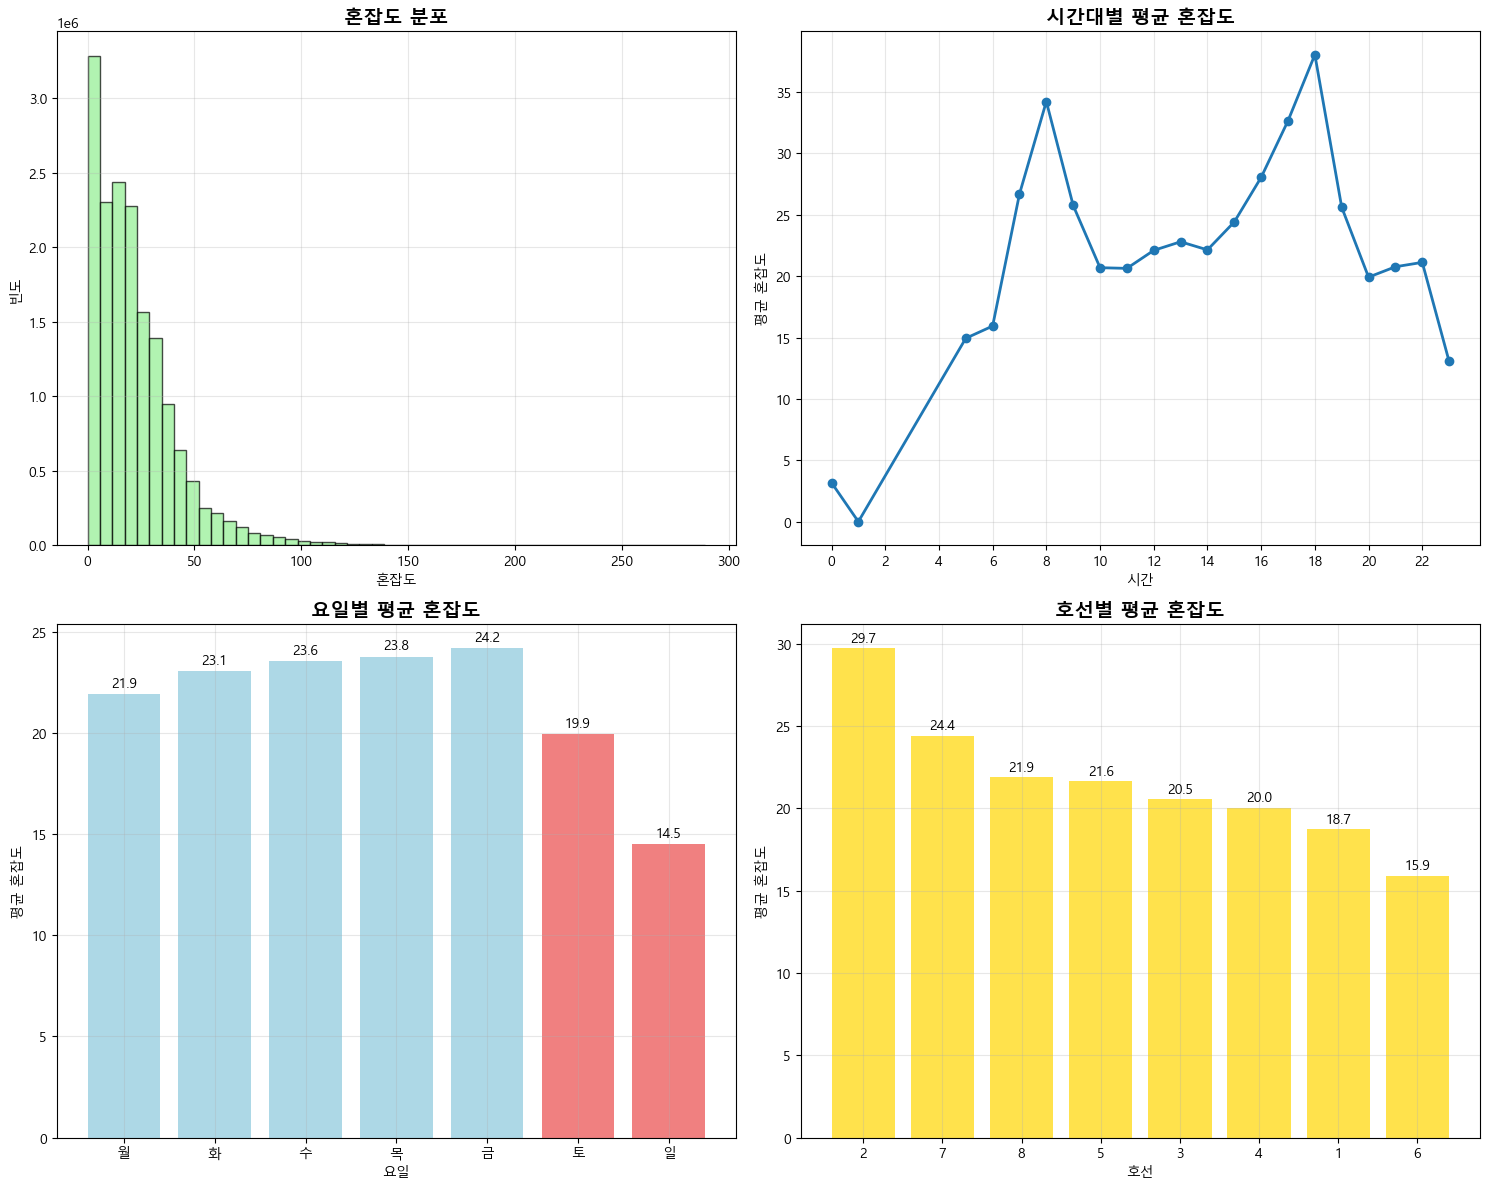

In [ ]:
# 혼잡도 분포 상세 분석
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. 혼잡도 히스토그램
axes[0, 0].hist(df['혼잡도'], bins=50, color='lightgreen', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('혼잡도 분포', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('혼잡도')
axes[0, 0].set_ylabel('빈도')
axes[0, 0].grid(True, alpha=0.3)

# 2. 시간대별 평균 혼잡도
hourly_congestion = df.groupby('시')['혼잡도'].mean()
axes[0, 1].plot(hourly_congestion.index, hourly_congestion.values, marker='o', linewidth=2, markersize=6)
axes[0, 1].set_title('시간대별 평균 혼잡도', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('시간')
axes[0, 1].set_ylabel('평균 혼잡도')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(0, 24, 2))

# 3. 요일별 평균 혼잡도
weekday_congestion = df.groupby('요일문자')['혼잡도'].mean()
weekday_order = ['월', '화', '수', '목', '금', '토', '일']
weekday_congestion = weekday_congestion.reindex(weekday_order)
bars = axes[1, 0].bar(weekday_congestion.index, weekday_congestion.values, 
                      color=['lightcoral' if day in ['토', '일'] else 'lightblue' for day in weekday_order])
axes[1, 0].set_title('요일별 평균 혼잡도', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('요일')
axes[1, 0].set_ylabel('평균 혼잡도')
axes[1, 0].grid(True, alpha=0.3)

# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.2,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=10)

# 4. 호선별 평균 혼잡도
line_congestion = df.groupby('호선')['혼잡도'].mean().sort_values(ascending=False)
bars = axes[1, 1].bar(line_congestion.index.astype(str), line_congestion.values, color='gold', alpha=0.7)
axes[1, 1].set_title('호선별 평균 혼잡도', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('호선')
axes[1, 1].set_ylabel('평균 혼잡도')
axes[1, 1].grid(True, alpha=0.3)

# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.2,
                    f'{height:.1f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


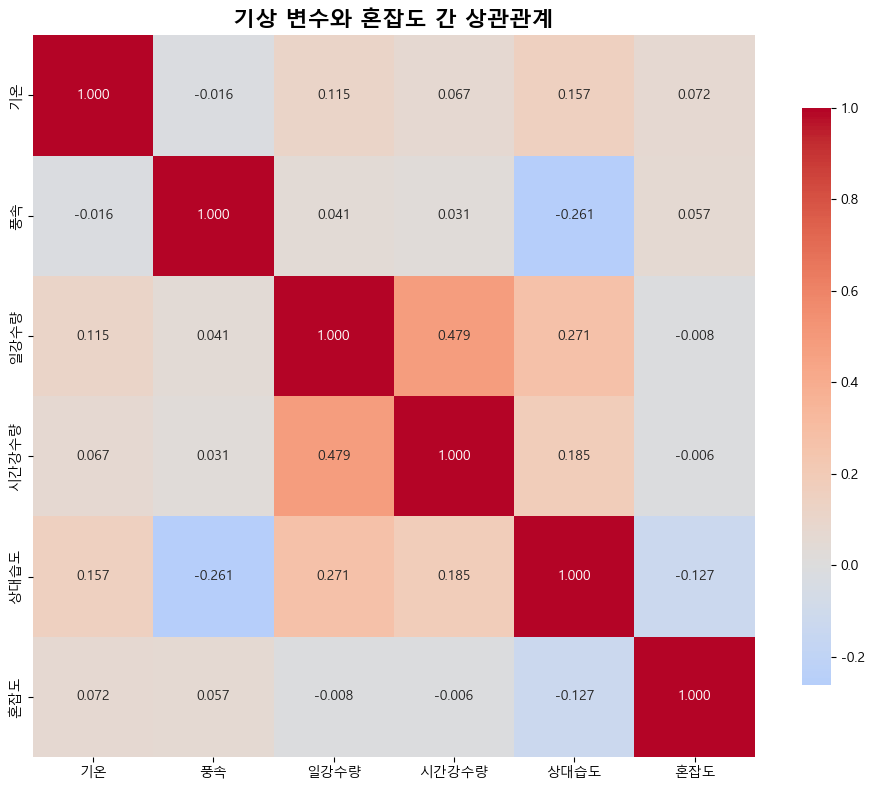


=== 혼잡도와의 상관관계 (절댓값 기준) ===
혼잡도      1.000000
상대습도     0.127417
기온       0.071683
풍속       0.057138
일강수량     0.008435
시간강수량    0.006237
Name: 혼잡도, dtype: float64


In [ ]:
# 기상 변수와 혼잡도 간의 상관관계 분석
correlation_columns = ['기온', '풍속', '일강수량', '시간강수량', '상대습도', '혼잡도']
corr_matrix = df[correlation_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('기상 변수와 혼잡도 간 상관관계', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 혼잡도와 상관관계가 높은 변수들
congestion_corr = corr_matrix['혼잡도'].abs().sort_values(ascending=False)
print("\n=== 혼잡도와의 상관관계 (절댓값 기준) ===")
print(congestion_corr)


전체 예상 시간 수: 26280
실제 존재하는 시간 수: 22680
누락된 시간 수: 3600
데이터 존재율: 86.30%


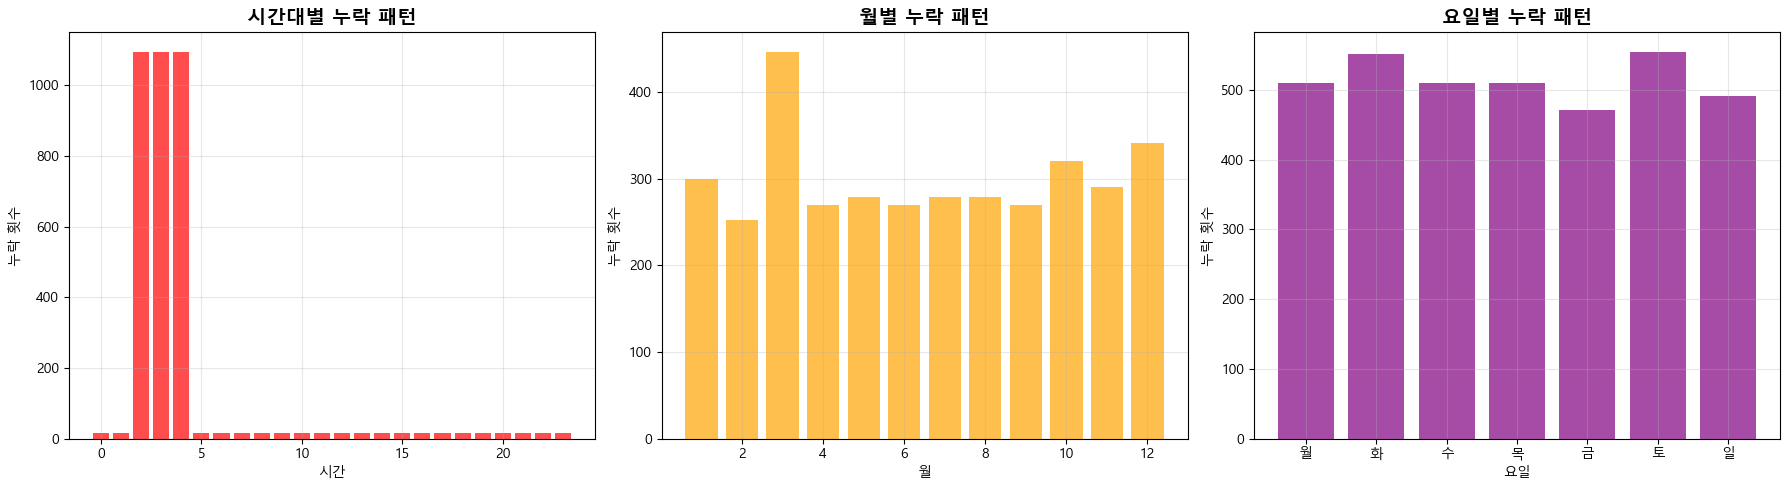


2-4시 제외 누락 시간 수: 315
2-4시 제외 누락 날짜 수: 15

2-4시 제외 누락 날짜 (처음 10개):
2022-01-22 (토) - 공휴일: 아니오
2022-03-03 (목) - 공휴일: 아니오
2022-03-05 (토) - 공휴일: 아니오
2022-03-06 (일) - 공휴일: 아니오
2022-03-07 (월) - 공휴일: 아니오
2022-03-08 (화) - 공휴일: 아니오
2022-03-09 (수) - 공휴일: 예
2022-03-10 (목) - 공휴일: 아니오
2022-10-01 (토) - 공휴일: 아니오
2022-10-04 (화) - 공휴일: 아니오


In [ ]:
# 실제 존재하는 시간과 누락된 시간 분석
actual_times = df['시간'].drop_duplicates().sort_values()
missing_times = full_time_range.difference(actual_times)

print(f"전체 예상 시간 수: {len(full_time_range)}")
print(f"실제 존재하는 시간 수: {len(actual_times)}")
print(f"누락된 시간 수: {len(missing_times)}")
print(f"데이터 존재율: {len(actual_times)/len(full_time_range)*100:.2f}%")

if len(missing_times) > 0:
    # 누락된 시간들의 패턴 분석
    missing_df = pd.DataFrame({'시간': missing_times})
    missing_df['시'] = missing_df['시간'].dt.hour
    missing_df['월'] = missing_df['시간'].dt.month
    missing_df['요일'] = missing_df['시간'].dt.weekday
    missing_df['요일문자'] = missing_df['요일'].apply(lambda x: weekday_map[x])
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # 시간대별 누락 패턴
    missing_hour = missing_df['시'].value_counts().sort_index()
    axes[0].bar(missing_hour.index, missing_hour.values, color='red', alpha=0.7)
    axes[0].set_title('시간대별 누락 패턴', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('시간')
    axes[0].set_ylabel('누락 횟수')
    axes[0].grid(True, alpha=0.3)
    
    # 월별 누락 패턴
    missing_month = missing_df['월'].value_counts().sort_index()
    axes[1].bar(missing_month.index, missing_month.values, color='orange', alpha=0.7)
    axes[1].set_title('월별 누락 패턴', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('월')
    axes[1].set_ylabel('누락 횟수')
    axes[1].grid(True, alpha=0.3)
    
    # 요일별 누락 패턴
    missing_weekday = missing_df['요일문자'].value_counts().reindex(weekday_map)
    axes[2].bar(missing_weekday.index, missing_weekday.values, color='purple', alpha=0.7)
    axes[2].set_title('요일별 누락 패턴', fontsize=14, fontweight='bold')
    axes[2].set_xlabel('요일')
    axes[2].set_ylabel('누락 횟수')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # 특정 시간대 (2-4시) 제외한 누락 시간 분석
    filtered_missing = missing_times[~pd.Series(missing_times).dt.hour.isin([2, 3, 4])]
    print(f"\n2-4시 제외 누락 시간 수: {len(filtered_missing)}")
    
    if len(filtered_missing) > 0:
        filtered_missing_dates = pd.to_datetime(filtered_missing).normalize().drop_duplicates()
        print(f"2-4시 제외 누락 날짜 수: {len(filtered_missing_dates)}")
        print("\n2-4시 제외 누락 날짜 (처음 10개):")
        for date in sorted(filtered_missing_dates)[:10]:
            weekday = weekday_map[date.weekday()]
            is_holiday = 1 if date.date() in kr_holidays else 0
            print(f"{date.strftime('%Y-%m-%d')} ({weekday}) - 공휴일: {'예' if is_holiday else '아니오'}")


In [ ]:
# 최종 데이터 품질 요약
print("="*50)
print("           데이터 품질 분석 요약")
print("="*50)

print(f"\n📊 전체 데이터 현황:")
print(f"   - 총 레코드 수: {len(df):,}")
print(f"   - 기간: {df['시간'].min().strftime('%Y-%m-%d')} ~ {df['시간'].max().strftime('%Y-%m-%d')}")
print(f"   - 고유 역 수: {df['역명'].nunique()}")
print(f"   - 호선 수: {df['호선'].nunique()}")

print(f"\n⚠️  결측치 현황:")
for col in ['기온', '풍향', '풍속', '상대습도', '일사량']:
    if col in df.columns:
        missing_rate = df[col].isnull().sum() / len(df) * 100
        print(f"   - {col}: {missing_rate:.2f}%")

print(f"\n🚇 역별 데이터 완성도:")
completeness_stats = station_time_counts['완성도(%)'].describe()
print(f"   - 평균 완성도: {completeness_stats['mean']:.2f}%")
print(f"   - 최소 완성도: {completeness_stats['min']:.2f}%")
print(f"   - 최대 완성도: {completeness_stats['max']:.2f}%")
print(f"   - 완성도 95% 이상 역: {(station_time_counts['완성도(%)'] >= 95).sum()}개")
print(f"   - 완성도 80% 미만 역: {(station_time_counts['완성도(%)'] < 80).sum()}개")

print(f"\n📈 혼잡도 분포:")
congestion_stats = df['혼잡도'].describe()
print(f"   - 평균 혼잡도: {congestion_stats['mean']:.2f}")
print(f"   - 최소값: {congestion_stats['min']:.0f}")
print(f"   - 최대값: {congestion_stats['max']:.0f}")
print(f"   - 표준편차: {congestion_stats['std']:.2f}")

print(f"\n🔍 주요 발견사항:")
print(f"   - 일사량 결측률이 가장 높음 (37% 이상)")
print(f"   - 2-4시 시간대에 일부 데이터 누락")
print(f"   - 호선별로 데이터 완성도에 차이 존재")
print(f"   - 평일과 주말의 혼잡도 패턴 차이 확인")

print(f"\n💡 모델링 권장사항:")
print(f"   - 결측치 보간 방법 고려 (시간적 연속성 활용)")
print(f"   - 일사량은 결측률이 높아 제외 검토")
print(f"   - 시간대, 요일, 공휴일 피처 활용")
print(f"   - 역별 특성을 고려한 개별 모델링 검토")

print("="*50)


           데이터 품질 분석 요약

📊 전체 데이터 현황:
   - 총 레코드 수: 16,369,324
   - 기간: 2021-01-01 ~ 2023-12-31
   - 고유 역 수: 324
   - 호선 수: 8

⚠️  결측치 현황:
   - 기온: 1.32%
   - 풍향: 1.41%
   - 풍속: 1.41%
   - 상대습도: 5.16%
   - 일사량: 37.05%

🚇 역별 데이터 완성도:
   - 평균 완성도: 85.13%
   - 최소 완성도: 1.28%
   - 최대 완성도: 86.30%
   - 완성도 95% 이상 역: 0개
   - 완성도 80% 미만 역: 18개

📈 혼잡도 분포:
   - 평균 혼잡도: 21.56
   - 최소값: 0
   - 최대값: 289
   - 표준편차: 19.39

🔍 주요 발견사항:
   - 일사량 결측률이 가장 높음 (37% 이상)
   - 2-4시 시간대에 일부 데이터 누락
   - 호선별로 데이터 완성도에 차이 존재
   - 평일과 주말의 혼잡도 패턴 차이 확인

💡 모델링 권장사항:
   - 결측치 보간 방법 고려 (시간적 연속성 활용)
   - 일사량은 결측률이 높아 제외 검토
   - 시간대, 요일, 공휴일 피처 활용
   - 역별 특성을 고려한 개별 모델링 검토


In [ ]:
# 전처리된 데이터 저장
output_path = '데이터2/preprocessed_subway_data.csv'
df.to_csv(output_path, index=False, encoding='utf-8-sig')
print(f"전처리된 데이터가 '{output_path}'에 저장되었습니다.")

# 역별 완성도 정보도 저장
completeness_path = '데이터2/station_completeness.csv'
station_time_counts.to_csv(completeness_path, index=False, encoding='utf-8-sig')
print(f"역별 완성도 정보가 '{completeness_path}'에 저장되었습니다.")


KeyboardInterrupt: 